In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


In [7]:
bond1 = 'Price History_20+_US_TBills.xlsx'
bond2 = 'Price History_7-10_US_TBills.xlsx'
equity = 'Price History_IVV_US_Equity.xlsx'
gold = 'Price History_IAU_Gold_Trust.xlsx'
# Load the Excel file into a DataFrame
df = pd.read_excel(options1)


NameError: name 'options1' is not defined

In [ ]:
def simulate_investment(file_path, initial_money):
    """
    Simulates an investment in a single asset using its closing prices.
    Handles missing or corrupted data and ensures proper date parsing.
    
    Args:
        file_path (str): Path to the Excel file containing asset data.
        initial_money (float): Initial amount of money to invest.
    Returns:
        float: Final value of the investment.
    """
    # Load the Excel file into a DataFrame
    data = pd.read_excel(file_path)
    
    # Ensure 'Exchange Date' is a datetime type
    data['Exchange Date'] = pd.to_datetime(data['Exchange Date'], errors='coerce')
    
    # Convert 'Close' to numeric and handle errors
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    # Drop rows with missing or invalid values
    data = data.dropna(subset=['Exchange Date', 'Close'])
    
    # Sort data by date
    data = data.sort_values(by='Exchange Date')
    
    # Debugging: Print data info and ranges
    print(f"Data Range: {data['Exchange Date'].iloc[0]} to {data['Exchange Date'].iloc[-1]}")
    print(f"Initial few rows:\n{data.head()}")
    print(f"Last few rows:\n{data.tail()}")
    
    # Extract closing prices and dates
    dates = data['Exchange Date']
    closing_prices = data['Close']
    
    # Check if data is valid
    if closing_prices.empty:
        print("Error: No valid closing prices found.")
        return None
    
    # Calculate the number of units purchased on the first day
    initial_price = closing_prices.iloc[0]
    units = initial_money / initial_price
    
    # Calculate portfolio value over time
    portfolio_values = units * closing_prices
    
    # Plot the portfolio value over time (spanning full date range)
    plt.figure(figsize=(14, 7))
    plt.plot(dates, portfolio_values, label='Portfolio Value', color='blue')
    plt.title("Investment Growth Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (USD)")
    plt.legend()
    plt.grid()
    plt.xlim([dates.iloc[0], dates.iloc[-1]])  # Ensure graph spans from earliest to latest date
    plt.tight_layout()
    plt.show()
    
    # Return the final portfolio value
    final_value = portfolio_values.iloc[-1]
    percent = (final_value / capital)*100
    return f"Portfolio Value: ${final_value:,.2f}"

In [15]:
def simulate_portfolio(file_paths, initial_money):
    """
    Simulates a portfolio investment in multiple assets using the 1/N strategy.
    Calculates common investment metrics including VaR.
    
    Args:
        file_paths (list): List of file paths to the Excel files for each asset.
        initial_money (float): Total initial amount of money to invest.
    Returns:
        dict: A dictionary containing final portfolio value and investment metrics.
    """
    # Remove duplicate file paths
    unique_file_paths = list(set(file_paths))
    
    # Determine allocation per asset
    n_assets = len(unique_file_paths)
    if n_assets == 0:
        return {"Error": "No valid assets provided."}
    
    money_per_asset = initial_money / n_assets
    
    # Dictionary to store individual asset portfolio values over time
    all_portfolio_values = {}
    
    # Iterate through each unique file and simulate investment
    for file_path in unique_file_paths:
        # Load the Excel file into a DataFrame
        data = pd.read_excel(file_path)
        
        # Ensure 'Exchange Date' is a datetime type
        data['Exchange Date'] = pd.to_datetime(data['Exchange Date'], errors='coerce')
        
        # Convert 'Close' to numeric and handle errors
        data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
        
        # Drop rows with missing or invalid values
        data = data.dropna(subset=['Exchange Date', 'Close'])
        
        # Sort data by date
        data = data.sort_values(by='Exchange Date')
        
        # Extract closing prices and dates
        dates = data['Exchange Date']
        closing_prices = data['Close']
        
        # Calculate the number of units purchased on the first day
        initial_price = closing_prices.iloc[0]
        units = money_per_asset / initial_price
        
        # Calculate portfolio value over time
        portfolio_values = units * closing_prices
        
        # Store the portfolio values with corresponding dates
        all_portfolio_values[file_path] = pd.DataFrame({
            'Date': dates,
            'Portfolio Value': portfolio_values
        })
    
    # Combine all portfolio values into a single DataFrame
    combined_data = pd.concat([df.set_index('Date') for df in all_portfolio_values.values()], axis=1)
    combined_data['Total Portfolio Value'] = combined_data.sum(axis=1)
    combined_data = combined_data.sort_index()  # Ensure sorted by date
    
    # Portfolio value over time
    portfolio_values = combined_data['Total Portfolio Value']
    
    # Metrics Calculation
    starting_value = portfolio_values.iloc[0]
    ending_value = portfolio_values.iloc[-1]
    total_days = (portfolio_values.index[-1] - portfolio_values.index[0]).days
    total_years = total_days / 365.0
    
    # 1. CAGR
    cagr = ((ending_value / starting_value) ** (1 / total_years)) - 1
    
    # 2. Volatility (Standard Deviation of Daily Returns)
    daily_returns = portfolio_values.pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility
    
    # 3. Max Drawdown
    rolling_max = portfolio_values.cummax()
    drawdowns = (portfolio_values - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    
    # 4. Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
    
    # 5. Value at Risk (99% Confidence)
    var_99 = daily_returns.quantile(0.01)  # 1st percentile of returns
    
    # Plot the combined portfolio value over time
    plt.figure(figsize=(14, 7))
    plt.plot(combined_data.index, portfolio_values, label='Total Portfolio Value', color='blue')
    plt.title("Portfolio Growth Over Time (1/N Strategy)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (USD)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # Return metrics and final portfolio value
    return {
        "Final Portfolio Value": f"${ending_value:,.2f}",
        "CAGR": f"{cagr:.2%}",
        "Volatility": f"{volatility:.2%}",
        "Max Drawdown": f"{max_drawdown:.2%}",
        "Sharpe Ratio": f"{sharpe_ratio:.2f}",
        "99% VaR": f"{var_99:.2%} "
    }

In [16]:
capital = 1000000

In [17]:
file_paths = [gold, equity]

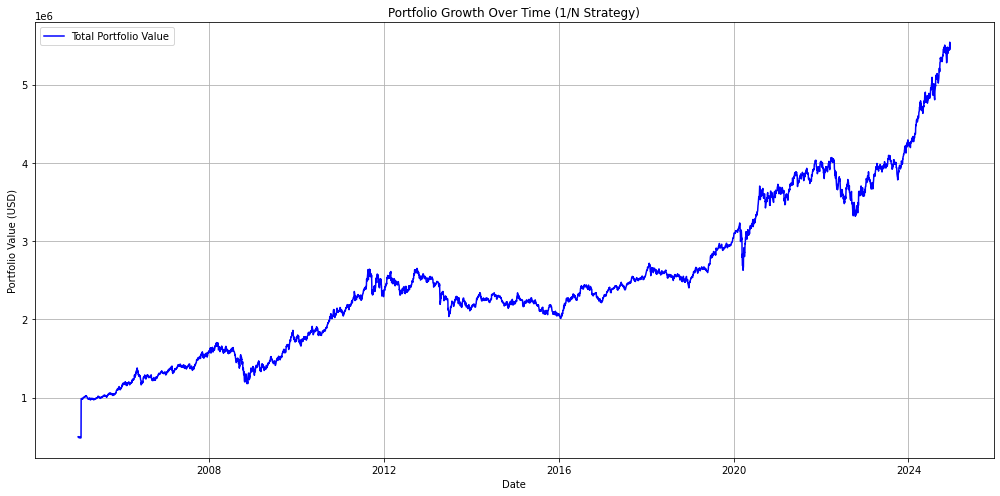

{'Final Portfolio Value': '$5,450,875.01',
 'CAGR': '12.72%',
 'Volatility': '26.62%',
 'Max Drawdown': '-30.79%',
 'Sharpe Ratio': '0.55',
 '99% VaR': '-2.39% '}

In [18]:
simulate_portfolio(file_paths, capital)
##simulate_investment(options1, capital)